# Imprting necessary **libraries**

In [ ]:
import tensorflow as tf 
import cv2
import numpy as np

# Getting and preprocessing the dataset 

## Getting the dataset
- The dataset that I'm gonna work with is the fer2013 from kaggle
1. mounting google drive into my notebook
1. Showing the files that contains the dataset

In [ ]:
# 1. First mounting google drive into /content/gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# 2. This is our dataset
!ls /content/gdrive/MyDrive/ColabNotebooks/datasets

archive.zip


In [ ]:
# 3. making a directory and moving the data on it to extract it
!mkdir /content/dataset
!cp /content/gdrive/MyDrive/ColabNotebooks/datasets/archive.zip /content/dataset/

mkdir: cannot create directory ‘/content/dataset’: File exists


In [ ]:
# 4. Unzipping the dataset
import zipfile
with zipfile.ZipFile('/content/dataset/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset/')

In [ ]:
!ls /content/dataset/

archive.zip  test  train


**Now I've imported the data from drive and extracted it succesfully into /content/dataset**

## Preprocessing the dataset

In [ ]:
import matplotlib.pyplot as plt

- Plotting a sample image 

The shape of the image is (48, 48, 3)


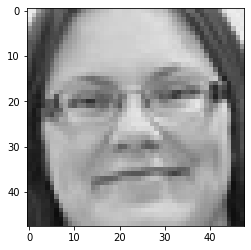

In [ ]:
train_path = '/content/dataset/train'
sample_img = cv2.imread(train_path + '/happy/Training_1206.jpg')
print(f"The shape of the image is {sample_img.shape}")
plt.imshow(sample_img)

### I'm gonna use Transefer learning here so I must preprocess the images to work with the resnet archticture.
1. Extract every image from its folder (happy, sad, etc) in the `train` folder
1. Label them as happy = 0, sad = 1 etc.
1. put those images into a numpy array assigned to every image its label 

In [ ]:
sample_img_rsz = np.resize(sample_img, (224,224,3))

In [ ]:
# adding a label for the above sample_img
# and resizing it to match the input shape of resnet (224, 224, 3)
sample_imgarr = np.array([np.resize(sample_img, (224,224,3)), 0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
print(sample_imgarr.shape)
print(sample_imgarr[0].shape)

(2,)
(224, 224, 3)


### Renaming folders 

In [ ]:
# Those are the folders that the data divided into
!ls /content/dataset/train

angry  disgust	fear  happy  neutral  sad  surprise


In [ ]:
import os

In [ ]:
# creating lablels and renaming the folders
labels = {"angry": 0, "disgust": 1, "fear": 2, "happy": 3, 
          "neutral": 4, "sad": 5, "surprise": 6}

# Renaming these local folders
for folder in os.listdir('/content/dataset/train/'):
  num = labels[folder]
  os.rename(f'/content/dataset/train/{folder}', f'/content/dataset/train/{num}')


In [ ]:
# Succesfully renamed
!ls /content/dataset/train

0  1  2  3  4  5  6


### Extracting every image and put it in an array
1. Extract the image
1. resizing it
1. labeling that image
1. append it to an array

In [ ]:
train_path

'/content/dataset/train'

In [ ]:
train_ds = []

def prepare_ds(ds_path):
  for folder in os.listdir(ds_path):
    for img_name in os.listdir(ds_path + f'/{folder}'):
      # print(ds_path + f'/{folder}/{img_name}')

      # reading the img
      img = cv2.imread(ds_path + f'/{folder}/{img_name}')

      #Resizing and adding the folder name as the label
      img_arr = np.array([np.resize(img, (224,224,3)), int(folder)])

      # append it to the big numpy list
      train_ds.append(img_arr)


In [ ]:
prepare_ds(train_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


In [ ]:
print(f'Number of images {len(train_ds)}')
print(f'shape of our images {train_ds[0][0].shape}')
print(f'The label of our first images {train_ds[0][1]}')

Number of images 28709
shape of our images (224, 224, 3)
The label of our first images 2


***Now I've succesfully imported the data in the requried format for the transefer learning step***

# Building the model

### Loading the model from keras

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model = tf.keras.applications.MobileNetV2()

14540800/14536120 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Transefer learning

In [ ]:
base_in = model.layers[0].input

In [ ]:
base_in

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_2')>

- **This is the input layer that we were preparing the data for**
- **We will need it when we build our own model after the editing**

In [ ]:
base_out = model.layers[-2].output

In [ ]:
base_out

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d_1')>

- ***The base_out simply contains all the loaded model except the last layer wich contains the 1000 class, so we get ride of it because we only have 7 classes***
- ***And I want to add some layers to train my images on, so it takes the basics features (the loaded model) and customize its out to my dataset***

In [ ]:
custom_model = layers.Dense(128)(base_out) #adding a layer on top of the loaded model
custom_model = layers.Activation('relu')(custom_model) # adding a nonlinearity activation fun
custom_model = layers.Dense(64)(custom_model) #adding another layer
custom_model = layers.Activation('relu')(custom_model)
## adding the output layer which will predicte seven calsses 
custom_model = layers.Dense(7, activation='softmax')(custom_model)

In [ ]:
custom_model

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'dense_2')>

In [ ]:
final_model = keras.Model(inputs=base_in, outputs=custom_model)

In [ ]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

- **So this is my final_model**

### Compiling the custom model

In [ ]:
final_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### more preprocessing

#### Shuffling the data

In [ ]:
import random
random.shuffle(train_ds)

- Splitting the data into X, and Y

In [ ]:
imgs = [element[0] for element in train_ds]

In [ ]:
labels = [element[1] for element in train_ds]

In [ ]:
print(len(imgs))
print(len(labels))

28709
28709


# Training the final model

In [ ]:
## Just rerun the previous cells then train the model
final_model.fit(imgs, labels, epochs=10)